In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image
import os
from os import path,listdir,walk
from matplotlib import image
import numpy as np
import random
import numpy as np
import threading
import re
from concurrent.futures import ProcessPoolExecutor

#File size was large. So, manually downloaded and uploaded the image dataset
#Download_Link:
#imageURL = 'http://web4.cs.ucl.ac.uk/staff/g.brostow/MotionSegRecData/files/701_StillsRaw_full.zip'
#labelURL = 'http://web4.cs.ucl.ac.uk/staff/g.brostow/MotionSegRecData/data/LabeledApproved_full.zip'

IMG_DIR = 'data/CamVid/images//'
LAB_DIR = 'data/CamVid/labels/'


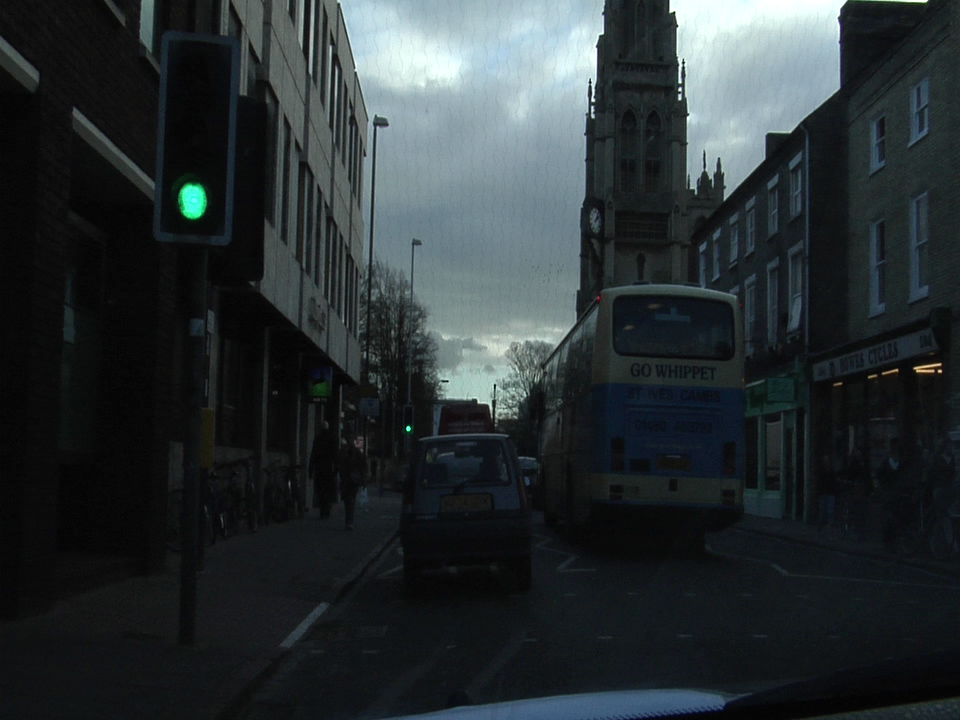

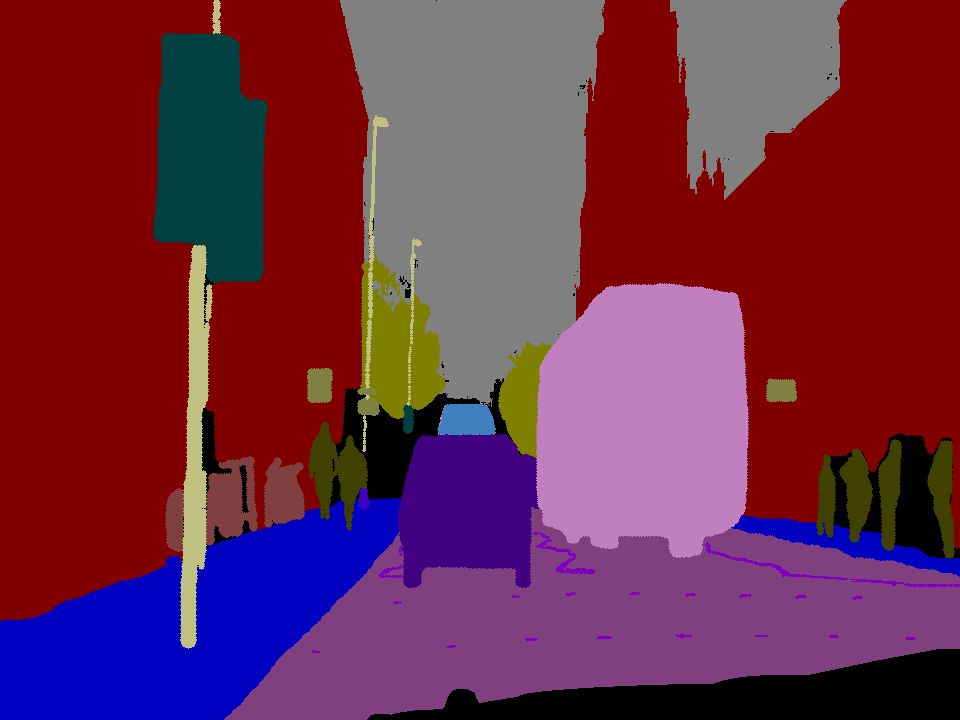

In [2]:
def get_y_fn(x,directory):
    filename=os.path.basename(x)
    split=os.path.splitext(filename)
    labelname=split[0]+'_L'+split[1]
    labelpath=path.join(directory,labelname)
    return labelpath

ids = listdir(IMG_DIR)
labels=listdir(LAB_DIR)
images_names = [path.join(IMG_DIR, image_id) for image_id in ids if path.isfile(path.join(IMG_DIR, image_id))]
labels_names = [i for i in (get_y_fn(image_id,LAB_DIR) for image_id in os.listdir(IMG_DIR)) if path.isfile(i) ]

#plotting original image
train_image = Image.open(images_names[171])
labels= Image.open(labels_names[171])
train_image.show()
labels.show()


((701, 256, 256, 3), (701, 256, 256, 3))

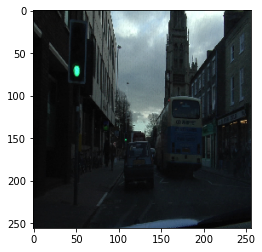

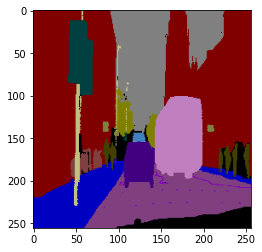

In [3]:
#function for resizing the image
def open_image(fn): 
    img_sz=(256,256)
    return np.array(Image.open(fn).resize(img_sz, Image.NEAREST))

#Loading imag,resizing and normalizing
imgs = np.stack([open_image(fn) for fn in images_names])/255
labels = np.stack([open_image(fn) for fn in labels_names])

#plotting resized image
plt.imshow(imgs[171]);
plt.figure()
plt.imshow(labels[171]);
imgs.shape,labels.shape

In [4]:
#function_for_reading_a_text_file
def parse_code(l):
    a,b = re.split('\\t+', l)  # - splits on one or more subsequent tabs, should they occur
    return tuple(int(o) for o in a.split(' ')), b[:-1]  # - [:-1] leaves out the newline at the end of each line

# Reading file labels_color
# Manually uploaded the file labels_color.txt
# Uploaded in github
label_codes, label_names = zip(*[
    parse_code(l) for l in open("data/CamVid/labels_color.txt")
])

label_codes, label_names = list(label_codes),list(label_names)

#providing id for label-codes
#incuding an integer for erroganeous value
code2id = {v:k for k,v in enumerate(label_codes)}

label_codes.append((0,0,0))
label_names.append('unk')

list(zip(label_codes,label_names))

[((128, 128, 128), 'Sky'),
 ((128, 0, 0), 'Building'),
 ((192, 192, 128), 'Column_Pole'),
 ((128, 64, 128), 'Road'),
 ((0, 0, 192), 'Sidewalk'),
 ((128, 128, 0), 'Tree'),
 ((192, 128, 128), 'Sign'),
 ((64, 64, 128), 'Fence'),
 ((64, 0, 128), 'Car'),
 ((64, 64, 0), 'Pedestrian'),
 ((0, 128, 192), 'Bicyclist'),
 ((0, 0, 0), 'Void'),
 ((0, 0, 0), 'unk')]

In [5]:
code2id

{(128, 128, 128): 0,
 (128, 0, 0): 1,
 (192, 192, 128): 2,
 (128, 64, 128): 3,
 (0, 0, 192): 4,
 (128, 128, 0): 5,
 (192, 128, 128): 6,
 (64, 64, 128): 7,
 (64, 0, 128): 8,
 (64, 64, 0): 9,
 (0, 128, 192): 10,
 (0, 0, 0): 11}

In [6]:
#checking all the label_codes and label_names
n,r,c,h = imgs.shape

failed_code = len(label_codes) + 1

#function_to_create_integer-mapped labels
def conv_one_label(i): 
    res = np.zeros((r,c), 'uint8')
    for j in range(r): 
        for k in range(c):
            try: 
                res[j,k] = code2id[tuple(labels[i,j,k])]
            except: 
                res[j,k] = failed_code
    return res


def conv_all_labels():
    ex = ProcessPoolExecutor(8)
    return np.stack(ex.map(conv_one_label, range(n)))


#create integer-mapped labels for all our colored images.
labels_int = conv_all_labels()

/home/vuran/prashant/.conda/envs/tensorflow-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
np.unique(labels_int.flatten())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 14], dtype=uint8)

In [8]:

#The 0 id might be associated with some label other than 'void', so let's look for the actual 'void' id
# - assign the 'void' id
labels_int[labels_int == failed_code] = label_codes.index((0,0,0))

print(labels_int.shape)

(701, 256, 256)


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test =  train_test_split(imgs, labels_int, test_size=0.20, random_state=42)


In [11]:
# Saving because I don't want to red
save_dir = "data/CamVid/np_saves/256_256"

np.save(save_dir+"/x_train", X_train)
np.save(save_dir+"/y_train", Y_train)

np.save(save_dir+"/x_test", X_test)
np.save(save_dir+"/y_test", Y_test)

